# Modeling a High Resolution Reflection Spectrum

In [1]:

from jax import config
config.update("jax_enable_x64", True)


Forget about the following code. I need this to run the code somewhere...

In [2]:

#username="exoplanet01"
username="kawahara"
if username == "exoplanet01":
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context



We need to get `JoviSpec`, the repository that contains the real reflection spectra of Jupiter. 

```sh
git clone https://github.com/HajimeKawahara/jovispec.git
python setup.py install
```


In [3]:
from jovispec import abcio
import pkg_resources


jupiter_data = pkg_resources.resource_filename("jovispec", "jupiter_data")

# red
rlambc, rspecc, rheadc = abcio.read_qfits("06033", jupiter_data, ext="q")
rlambw, rspecw, rheadw = abcio.read_qfits("06047", jupiter_data, ext="q")
rlambe, rspece, rheade = abcio.read_qfits("06049", jupiter_data, ext="q")

# rapid rotator
rlamb_ref, rspec_ref, rhead_ref = abcio.read_qfits(
    "06031", jupiter_data, ext="q"
)  # HD13041

# blue
# rlambc, rspecc, rheadc=abcio.read_qfits("06034",jupiter_data,ext="q")
# rlambw, rspecw, rheaadw=abcio.read_qfits("06048",jupiter_data,ext="q")
# rlambe, rspece, rheade=abcio.read_qfits("06050",jupiter_data,ext="q")

Sets the wavelength range

In [4]:
wavelength_start = 8500.0 #AA
wavelength_end = 8800.0 #AA

You find almost no telluric lines in this wavelength range

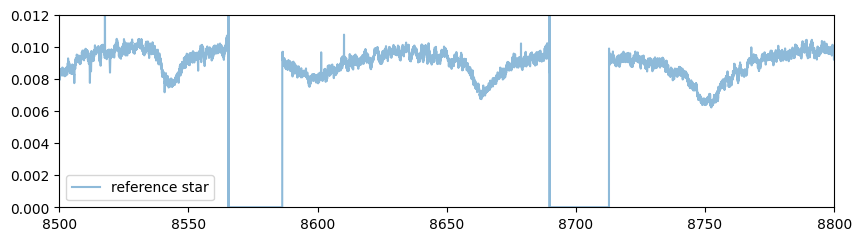

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(111)
plt.plot(rlamb_ref,rspec_ref,alpha=0.5,label="reference star")
plt.ylim(0.0,0.012)
plt.xlim(wavelength_start,wavelength_end)
plt.legend()
plt.show()

We observed the east edge, center, and west edge of the Jovian disk.
The rapid spin rotation yields different Doppler shift for these observataions

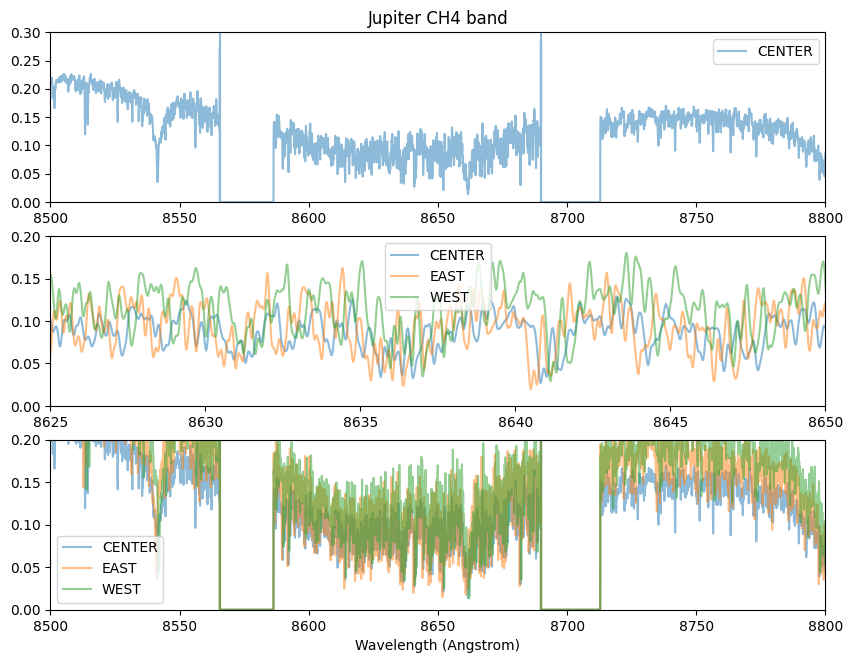

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(311)
plt.plot(rlambc,rspecc,alpha=0.5,label="CENTER")
#plt.plot(rlambe,rspece,alpha=0.5,label="EAST")
#plt.plot(rlambw,rspecw*0.7,alpha=0.5,label="WEST")
plt.ylim(0.0,0.3)
plt.xlim(wavelength_start,wavelength_end)
plt.legend()
plt.title("Jupiter CH4 band")

#plt.xlim(7150.0,7200.0)
ax = fig.add_subplot(312)
plt.plot(rlambc,rspecc,alpha=0.5,label="CENTER")
plt.plot(rlambe,rspece,alpha=0.5,label="EAST")
plt.plot(rlambw,rspecw*0.7,alpha=0.5,label="WEST")
plt.legend()
plt.ylim(0.0,0.2)
plt.xlim(wavelength_start,wavelength_end)
plt.xlim(8625,8650)

ax = fig.add_subplot(313)
plt.plot(rlambc,rspecc,alpha=0.5,label="CENTER")
plt.plot(rlambe,rspece,alpha=0.5,label="EAST")
plt.plot(rlambw,rspecw*0.7,alpha=0.5,label="WEST")
plt.legend()
plt.ylim(0.0,0.2)
plt.xlim(wavelength_start,wavelength_end)

plt.xlabel("Wavelength (Angstrom)")

plt.savefig("ch4jupiter.png")

Some messy procedure for astronomers...

In [7]:
import numpy as np

rlamb = rlambc
rspec = rspecc

# mask some bad regions... as usual in astronomy  
mask_wav = [
[8565.4, 8586.5],
[8689.5, 8713.0]
]
rlamb = np.array([float(d) for d in rlamb])
mask_index=np.digitize(mask_wav,rlamb)
for ind in mask_index:
    rspec[ind[0]:ind[1]+1] = None


# None for outside wvelength start - end region
start_index=np.digitize(wavelength_start,rlamb)
end_index=np.digitize(wavelength_end,rlamb)
rspec[:start_index] = None
rspec[end_index:] = None

#Air-Vaccum correction
from specutils.utils.wcs_utils import refraction_index
import astropy.units as u
mask = rspec == rspec
rlamb = rlamb[mask]
rspec = rspec[mask]
nair = refraction_index(rlamb*u.AA,method="Ciddor1996")
rlamb = rlamb*nair

# ascending wavenumber form
from exojax.spec.unitconvert import wav2nu
rlamb = rlamb[::-1]
nus_obs = wav2nu(rlamb, unit="AA")
rspec = rspec[::-1]


The following spectrum is the target we will analyze!

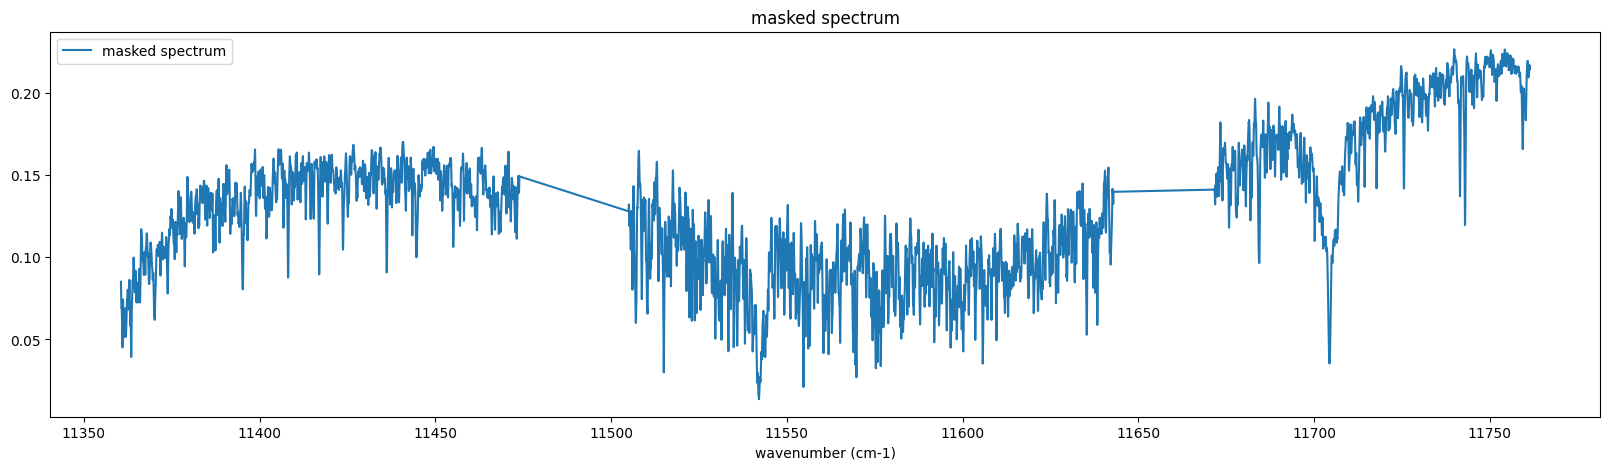

In [8]:
fig = plt.figure(figsize=(20,5))
plt.plot(nus_obs,rspec, label="masked spectrum")
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.title("masked spectrum")
plt.show()

### Telluric

Telluric lines stuff... ExoJAX can do that anyway.

In [9]:
from exojax.spec.api import MdbHitran
from exojax.spec.opacalc import OpaDirect
from exojax.spec.opacalc import OpaPremodit
from exojax.utils.grids import wavenumber_grid
from exojax.spec.unitconvert import wav2nu

N = 40000

margin = 10  # cm-1
nus_start = wav2nu(wavelength_end, unit="AA") - margin
nus_end = wav2nu(wavelength_start, unit="AA") + margin

mdb_water = MdbHitran("H2O", nurange=[nus_start, nus_end], isotope=1)
nus, wav, res = wavenumber_grid(nus_start, nus_end, N, xsmode="lpf", unit="cm-1")
opa_telluric = OpaPremodit(mdb_water, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 400.0])

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: mode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 79.45501192821337 - 740.1245313998245 K
Change the reference temperature from 296.0K to 91.89455622053987 K.


/home/kawahara/exojax/src/exojax/spec/set_ditgrid.py:52: UserWarning: There exists negative or zero value.
  warnings.warn("There exists negative or zero value.")


OpaPremodit: Tref_broadening is set to  178.88543819998304 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  22
# of temperature exponent grid : 7


uniqidx: 100%|██████████| 40/40 [00:00<00:00, 8626.71it/s]

Premodit: Twt= 328.42341041740974 K Tref= 91.89455622053987 K
Making LSD:|###############-----| 75%

Making LSD:|####################| 100%


Yes ah no, almost no telluric line confirmed...

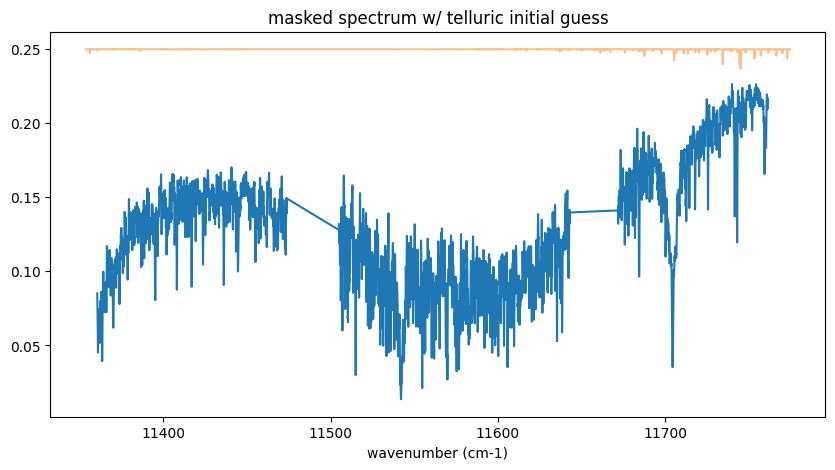

In [10]:
import jax.numpy as jnp

T = 200.0
P = 0.5
xsv = opa_telluric.xsvector(T, P)
nl = 1.0e22
a = 0.25

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.title("masked spectrum w/ telluric initial guess")
plt.plot(nus_obs, rspec)
#plt.ylim(0.0, 0.7)
plt.plot(nus, a * jnp.exp(-nl * xsv), alpha=0.5)
# plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)
plt.xlabel("wavenumber (cm-1)")

plt.show()

## Solar spectrum

This is the reflected "solar" spectrum by Jupiter! So, we need the solar spectrum template.

I found very good one: High-resolution solar spectrum taken from Meftar et al. (2023) 

- 10.21413/SOLAR-HRS-DATASET.V1.1_LATMOS
- http://doi.latmos.ipsl.fr/DOI_SOLAR_HRS.v1.1.html
- http://bdap.ipsl.fr/voscat_en/solarspectra.html


In [11]:

import pandas as pd
#filename = "/home/kawahara/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
filename = "/home/"+username+"/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
dat = pd.read_csv(filename, names=("wav","flux"), comment=";", delimiter="\t")
dat["wav"] = dat["wav"]*10

wav_solar = dat["wav"][::-1]
solspec = dat["flux"][::-1]
nus_solar = wav2nu(wav_solar,unit="AA")


This is really the solar spectrum reflected by something...

Text(0.5, 0, 'wavenumber (cm-1)')

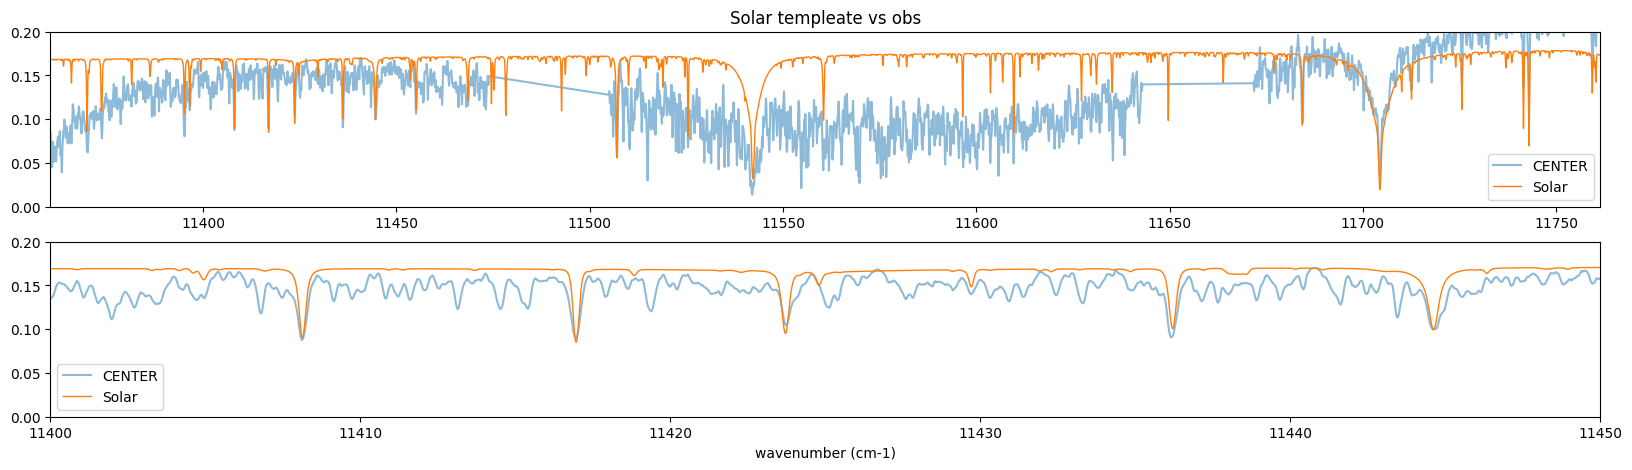

In [12]:
vperc = (106.5-82.5)/300000

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.plot(nus_obs,rspec,alpha=0.5,label="CENTER")
plt.plot(nus_solar*(1.0+vperc),solspec*0.17,lw=1,label="Solar")
plt.xlim(np.min(nus_obs),np.max(nus_obs))
plt.ylim(0.0,0.2)

plt.legend()
plt.title("Solar templeate vs obs")
ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,alpha=0.5,label="CENTER")
plt.plot(nus_solar*(1.0+vperc),solspec*0.17,lw=1,label="Solar")
plt.xlim(11400,11450)
plt.ylim(0.0,0.2)
plt.legend()
plt.xlabel("wavenumber (cm-1)")


## Atmospheric Model Setting

See `Jupiter_cloud_model_using_amp.ipynb` 


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


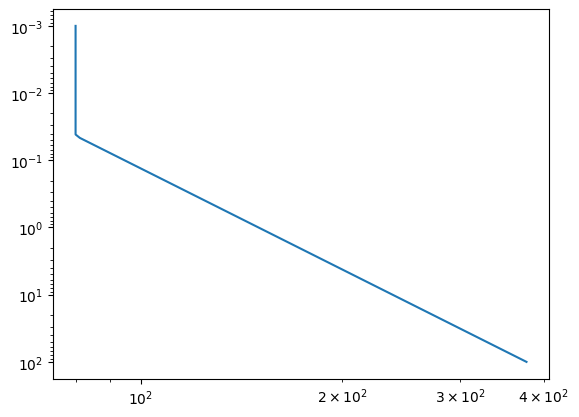

In [13]:
from exojax.spec.atmrt import ArtReflectPure
from exojax.utils.astrofunc import gravity_jupiter


art = ArtReflectPure(nu_grid=nus, pressure_btm=1.0e2, pressure_top=1.0e-3, nlayer=100)
art.change_temperature_range(80.0, 400.0)
Tarr = art.powerlaw_temperature(150.0, 0.2)
Parr = art.pressure

mu = 2.3  # mean molecular weight
gravity = gravity_jupiter(1.0, 1.0)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Tarr, art.pressure)
ax.invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [14]:


from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
amp_nh3 = AmpAmcloud(pdb_nh3, bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

#condensate substance density
rhoc = pdb_nh3.condensate_substance_density #g/cc

from exojax.utils.zsol import nsol
from exojax.atm.mixratio import vmr2mmr
from exojax.spec.molinfo import molmass_isotope

n = nsol()  #solar abundance
abundance_nh3 = n["N"]
molmass_nh3 = molmass_isotope("NH3", db_HIT=False)

fsed = 10.
sigmag = 2.0
Kzz = 1.e4
MMRbase_nh3 = vmr2mmr(abundance_nh3, molmass_nh3, mu) 

rg_layer, MMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, molmass_nh3, gravity, fsed, sigmag, Kzz, MMRbase_nh3)


.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file does not exist at  .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
Generate miegrid file using pdb.generate_miegrid if you use Mie scattering


/home/kawahara/exojax/src/exojax/atm/atmphys.py:50: UserWarning: min temperature 80.0 K is smaller than min(vfactor t range) 179.10000000000002 K
  warnings.warn(


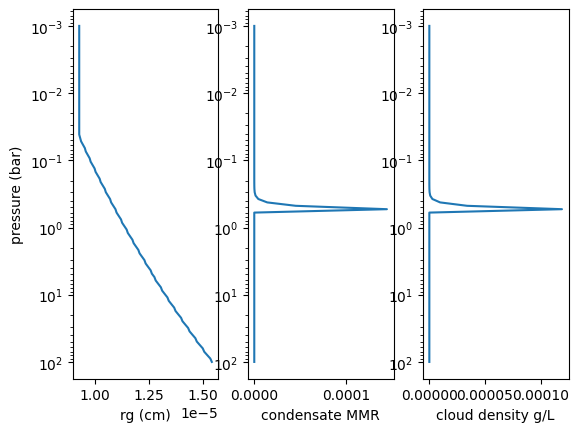

In [15]:
import matplotlib.pyplot as plt

# to convert MMR to g/L ... 
from exojax.atm.idealgas import number_density
from exojax.utils.constants import m_u
fac = molmass_nh3*m_u*number_density(Parr,Tarr)*1.e3 #g/L 

fig = plt.figure()
ax = fig.add_subplot(131)
plt.plot(rg_layer, Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(132)
plt.plot(MMRc, Parr)
plt.xlabel("condensate MMR")
plt.yscale("log")
#plt.xscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(133)
plt.plot(fac*MMRc, Parr)
plt.xlabel("cloud density g/L")
plt.yscale("log")
#plt.xscale("log")
ax.invert_yaxis()

In [16]:
rg = 1.e-5

from exojax.spec.opacont import OpaMie
opa = OpaMie(pdb_nh3, nus)
#sigma_extinction, sigma_scattering, asymmetric_factor = opa.mieparams_vector(rg,sigmag) # if using MieGrid
sigma_extinction, sigma_scattering, asymmetric_factor = opa.mieparams_vector_direct_from_pymiescatt(rg, sigmag)


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


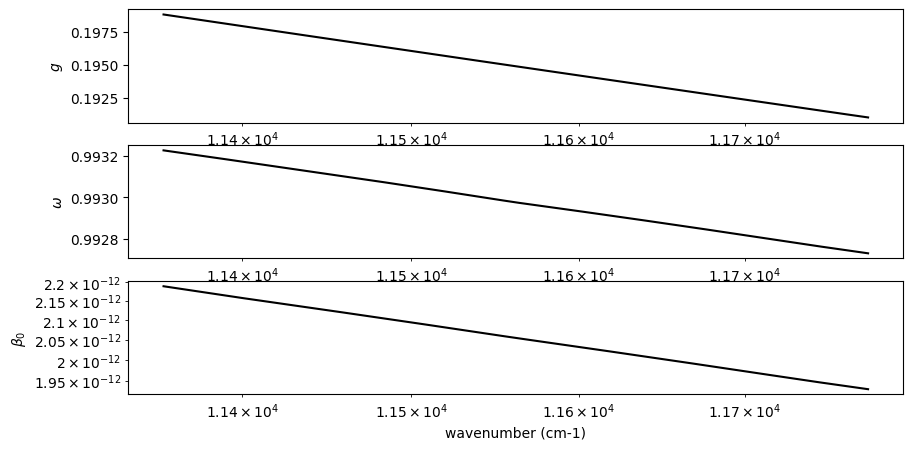

In [17]:
# plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(311)
plt.plot(nus, asymmetric_factor, color="black")
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(312)
plt.plot(nus, sigma_scattering/sigma_extinction, label="single scattering albedo", color="black")
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(313)
plt.plot(nus, sigma_extinction, label="ext", color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("$\\beta_0$")
plt.savefig("miefig_high.png")

Next, we consider the gas component, i.e. methane

In [18]:
from exojax.spec.api import MdbHitemp

Ignore the following unless you are interested in the elower max optimization

In [19]:
optimize = False #if you want to run the elower maximum optimization, turn True
if optimize:
    mdb = MdbHitemp("CH4", nurange=[nus_start,nus_end], isotope=1)
    from exojax.spec.optgrid import optelower
    Tmax = 400.0
    Pmin = 1.e-5
    Eopt = optelower(mdb, nus, Tmax, Pmin)

Oh, we need HITEMP because our observation is in visible band, i.e., we need higher energy states.

In [20]:
Eopt = 3300.0 # this is from the above optimization result
mdb_reduced = MdbHitemp("CH4", nurange=[nus_start,nus_end], isotope=1, elower_max=Eopt)

The optimization stuff, ignore

In [21]:
if optimize:
    plt.plot(mdb.elower,mdb.line_strength_ref,".",alpha=0.3)
    plt.plot(mdb_reduced.elower,mdb_reduced.line_strength_ref,".",alpha=0.5,color="C2")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("E lower (cm-1)")
    plt.ylabel("line strength at T="+str(mdb.Tref)+"K")
    plt.axvline(Eopt, color="C2")

In [22]:
opa = OpaPremodit(mdb_reduced, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0]) #this reduced the device memory use in 5/6.

OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 79.45501192821337 - 740.1245313998245 K
Change the reference temperature from 296.0K to 91.89455622053987 K.
OpaPremodit: Tref_broadening is set to  154.91933384829665 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  5
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 3/3 [00:00<00:00, 68.62it/s]


Premodit: Twt= 328.42341041740974 K Tref= 91.89455622053987 K
Making LSD:|####################| 100%


### cloud opacity

In [23]:
dtau_cld = art.opacity_profile_cloud_lognormal(sigma_extinction, rhoc, MMRc, rg, sigmag, gravity)

### gas opacity 

In [32]:
mmr_ch4 = art.constant_mmr_profile(0.01) # (*_*)/~
molmass_ch4 = molmass_isotope("CH4", db_HIT=False)

xsmatrix = opa.xsmatrix(Tarr,Parr)
dtau_ch4 = art.opacity_profile_xs(xsmatrix, mmr_ch4,molmass_ch4,gravity)

In [33]:
dtau_cld_scat = art.opacity_profile_cloud_lognormal(sigma_scattering, rhoc, MMRc, rg, sigmag, gravity)
single_scattering_albedo = (dtau_cld_scat)/(dtau_cld + dtau_ch4)

sigma_scattering[None,:]/sigma_extinction[None,:] + np.zeros((len(art.pressure), len(nus)))
asymmetric_parameter = asymmetric_factor + np.zeros((len(art.pressure), len(nus))) 
reflectivity_surface = np.zeros(len(nus))

In [34]:
dtau = dtau_cld + dtau_ch4

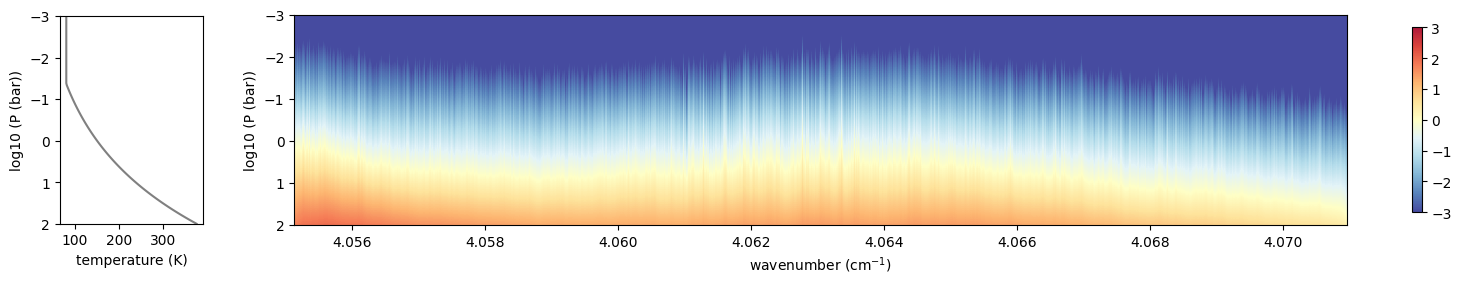

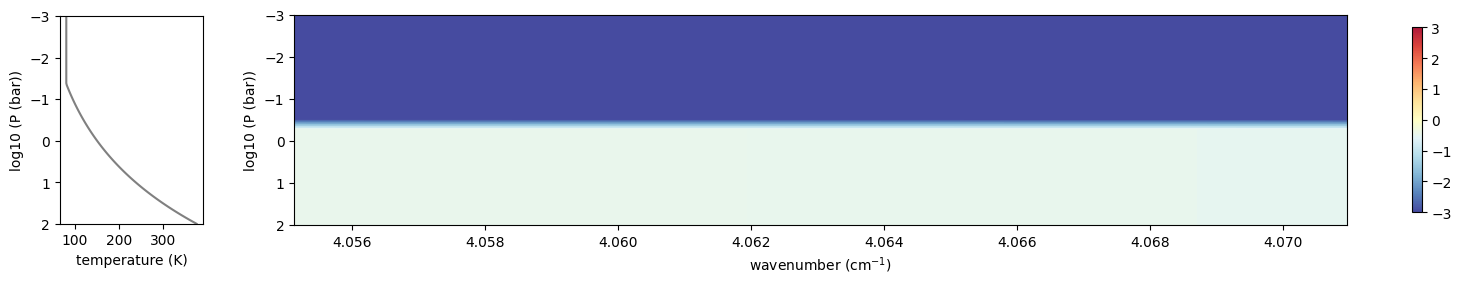

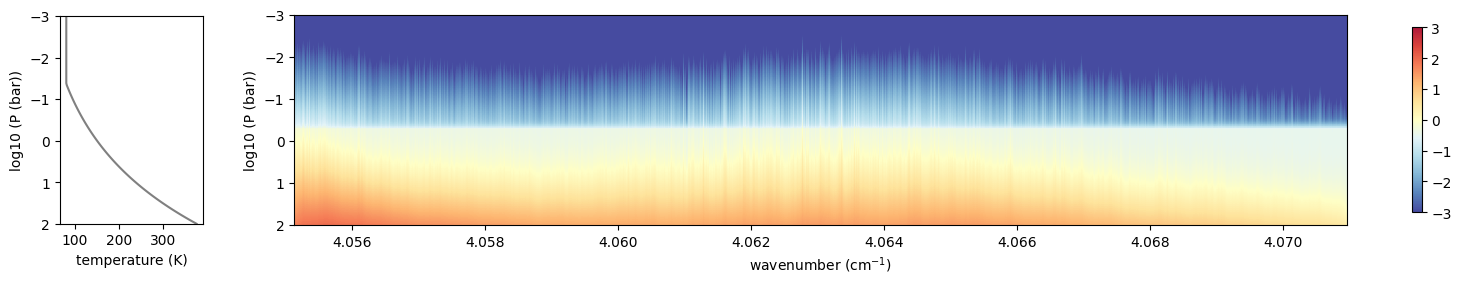

In [35]:
from exojax.plot.atmplot import plottau

plottau(np.log10(nus), dtau_ch4, Tarr, Parr)
plt.show()
plottau(np.log10(nus), dtau_cld, Tarr, Parr)
plt.show()
plottau(np.log10(nus), dtau, Tarr, Parr)

OK, uses the solar spectrum as an incomning spectrum! 

In [36]:
#incoming_flux = np.ones(len(nus))
incoming_flux = np.interp(nus, nus_solar*(1.0+vperc), solspec)
Fr = art.run(dtau,single_scattering_albedo,asymmetric_parameter,reflectivity_surface,incoming_flux)

from exojax.spec.specop import SopInstProfile
from exojax.utils.instfunc import R2STD
sop = SopInstProfile(nus)
res_inst = 80000.0
std = R2STD(res_inst)
Fr_inst= sop.ipgauss(Fr,std)


/home/kawahara/exojax/src/exojax/utils/instfunc.py:11: FutureWarning: Use `resolution_to_gaussian_std` instead
  warnings.warn(warn_msg, FutureWarning)


Recall that this is the forward modelling. So, the following results look not bad! If you have time change the MMR of CH4 (if you find the line of `(*_*)/~`)?

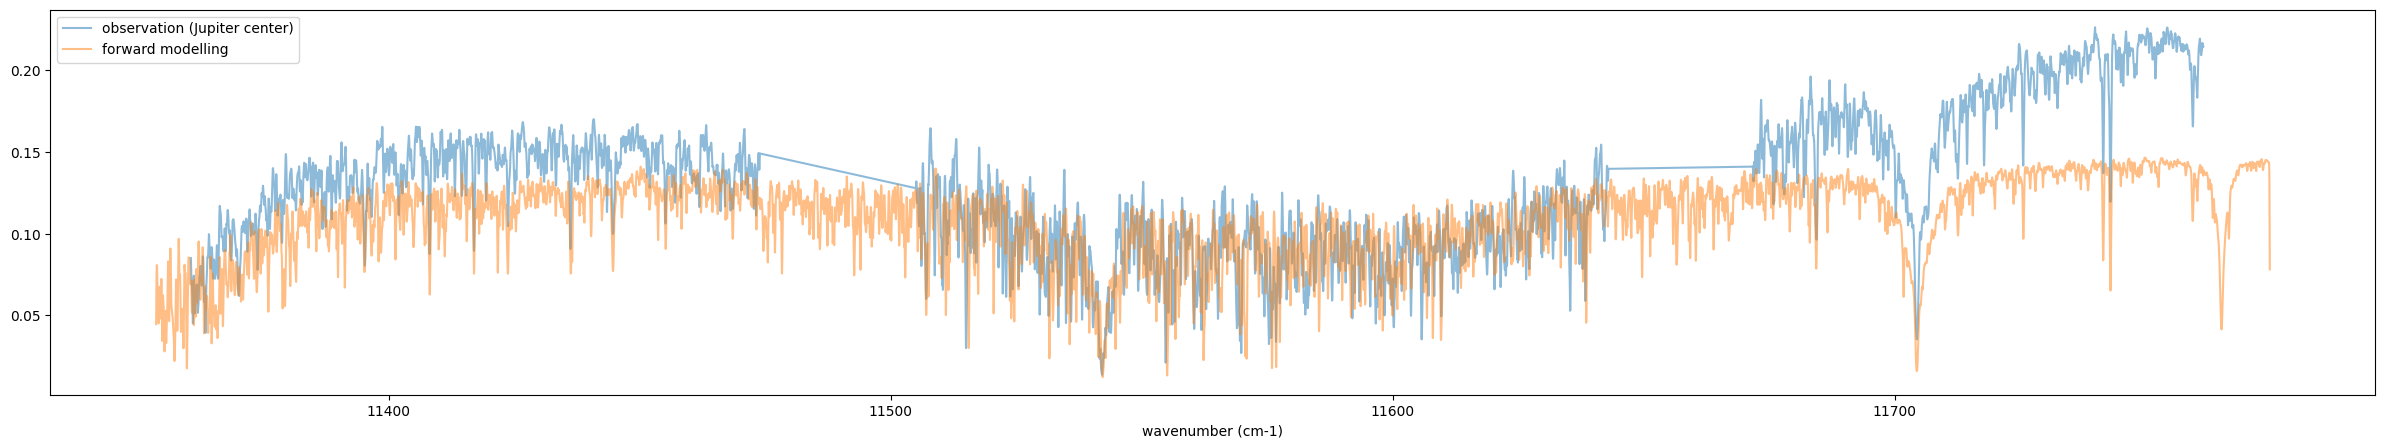

In [40]:
fig = plt.figure(figsize=(30,5))
plt.plot(nus_obs,rspec,alpha=0.5,label="observation (Jupiter center)")
plt.plot(nus,Fr_inst*0.7,alpha=0.5,label="forward modelling")
plt.legend()
plt.xlabel("wavenumber (cm-1)")
plt.savefig("Jupiter_forward.png")
plt.show()